# Project 2: Moneyball
### By: Alex Abadi


In [151]:
import sqlite3 as s
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
#matplotlib.style.use("ggplot")
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
matplotlib.style.use("dark_background")

# Part 1: Wrangling
The data you need to answer these questions is in the Salaries and Teams tables of the database.
## Problem 1
**Using SQL queries only** compute a relation containing the total payroll and winning percentage (number of wins / number of games * 100) for each team (that is, for each teamID and yearID combination). You should include other columns that will help when performing EDA later on (e.g., franchise ids, number of wins, number of games).


Include as a cell the SQL code you used to create this relation. As a markdown cell, describe how you dealt with any missing data in these two relations. Specifically, indicate if there is missing data in either table, and how the type of join you used determines how you dealt with this missing data.

**Hint:** Take a good look at the SQLite Documentation.

Include as a cell the SQL code you used to create this relation. As a markdown cell, describe how you dealt with any missing data in these two relations. Specifically, indicate if there is missing data in either table, and how the type of join you used determines how you dealt with this missing data.

**If you read the whole database into a file you will lose points, the SQL query you write should do all processing on the server side as discussed in class.**

**You must display the head of the resulting data table / dataframe in your notebook. You should also display the results of one team over the time range to make sure your data is correct. Note that this data table is the data frame you will use for the rest of the project.**

**Hint:** For SQL you have to be mindful of integer vs. float division. See the above tutorial on how to deal with this.

,yearID,teamID,total_payroll,W,G,franchID,win_rate
0,1997,ANA,31135472.0,84,162,ANA,51.851852
1,1998,ANA,41281000.0,85,162,ANA,52.469136
2,1999,ANA,55388166.0,70,162,ANA,43.209877
3,2000,ANA,51464167.0,82,162,ANA,50.617284
4,2001,ANA,47535167.0,75,162,ANA,46.296296
...,...,...,...,...,...,...,...
853,2010,WAS,61400000.0,69,162,WSN,42.592593
854,2011,WAS,63856928.0,80,161,WSN,49.689441
855,2012,WAS,80855143.0,98,162,WSN,60.493827
856,2013,WAS,113703270.0,86,162,WSN,53.086420


/tmp/ipykernel_40/1225913916.py:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  braves = braves[team_df.yearID > 1995]


(1995.0, 2014.0)

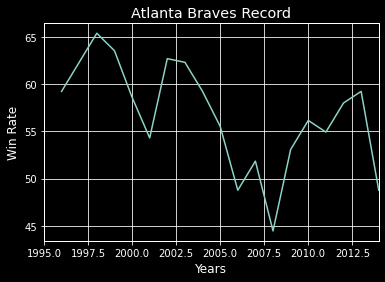

In [293]:
sqlite_file = 'lahman2014.sqlite' #Using the correct file
conn = sqlite3.connect(sqlite_file)

#SQL query to acquire data from the Salaries table
salaryq = '''SELECT 
                    yearID,
                    teamID,
                    sum(salary) as total_payroll 
                FROM 
                    Salaries
                GROUP BY
                    yearID, teamID 
                ORDER BY
                    teamID
'''
salaries = pd.read_sql(salaryq, conn)

#SQL query to acquire data from the Teams table
teamsq = '''SELECT 
                    W,
                    G,
                    teamID,
                    yearID,
                    franchID,
                    100*CAST(W AS float)/G as win_rate   
                FROM 
                    Teams 
                GROUP BY
                    yearID, teamID 
                ORDER BY
                    teamID
    '''
wins = pd.read_sql(teamsq, conn)

team_df = salaries.merge(wins, how ="inner",left_on=["yearID", "teamID"],right_on=["yearID", "teamID"])
display(team_df)

#fixed known mistake in data where the milwaukee brewers have teamID ML4 from 1985-1997 and MIL on all the others
team_df["teamID"].replace({"ML4": "MIL"}, inplace=True)

#Plotting results for the Atlanta Braves from 1995 to 2015
braves = team_df[team_df.teamID == "ATL"]
braves = braves[team_df.yearID > 1995]
plt.plot(braves["yearID"], braves["win_rate"])
plt.title("Atlanta Braves Record")
plt.xlabel("Years")
plt.ylabel("Win Rate")
plt.xlim([1995, 2014])
#Since Braves were founded in 1997, there is no data for 1995 and 1996

# Part 2: Exploratory Data Analysis

## Payroll Distribution
### Problem 2
Write code to produce a single plot that illustrates the distribution of payrolls across teams conditioned on time (from 1990-2014). This plot should be clear and interpretable. You will be graded on the clairty of the plot you decide to make.

Write code to produce a single scatter plot that shows winning percentage as a function of total payroll. That is, the total payroll on the x-axis and win percentage is on the y axis.

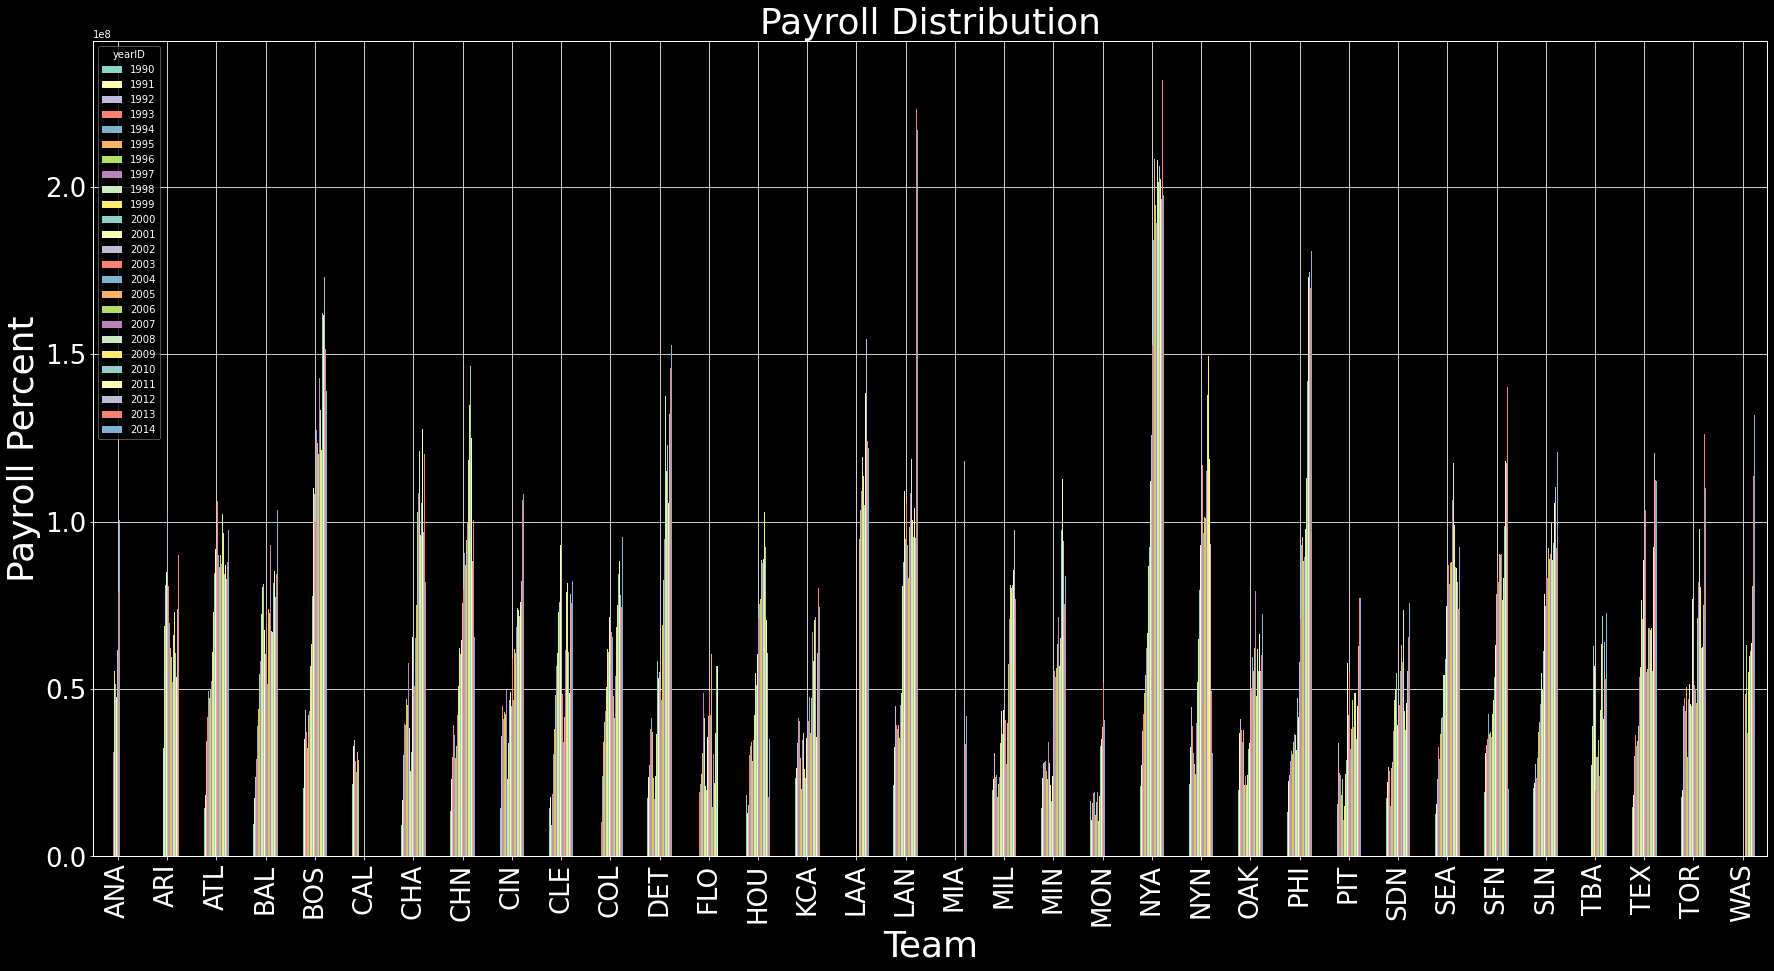

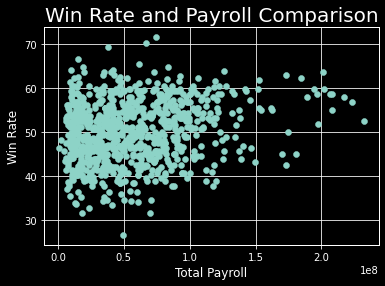

In [294]:
filtered = team_df[team_df.yearID > 1989]
filtered = filtered[filtered.yearID < 2015]
#Making pivot table to condense data
filtered = filtered.pivot(index ='teamID', columns='yearID', values='total_payroll')

#Payroll Plot
filtered.plot(kind = 'bar', stacked = False, figsize=(30, 15), legend=True, fontsize=26)
plt.xlabel("Team", fontsize=36)
plt.ylabel("Payroll Percent", fontsize=36)
plt.title("Payroll Distribution", fontsize=36)
plt.show() #Zoom in to deeply explore chart

#Scatter Plot
plt.scatter(team_df["total_payroll"], team_df["win_rate"])
plt.xlabel("Total Payroll", fontsize=12)
plt.ylabel("Win Rate", fontsize=12)
plt.title("Win Rate and Payroll Comparison", fontsize=20)
plt.show()

As observed in question 1, we see that the mean payroll of all teams are likely to increase over the years.

### **Question 1**
What statements can you make about the distribution of payrolls conditioned on time based on these plots? Remember you can make statements in terms of central tendency, spread, and other statistics discussed in class.

The distribution of payrolls is very clearly on an increasing trend as time moves forward. Most teams have their highest total salary in the most recent year. It is also apparent that popular and acheiving teams have budgets that are multiple times the amount than those who are not popular. For example, The Yankees and Redsox have the largest percent of total payroll in the MLB 

For the scatter plot we can see that the most successful teams are not necesarily the ones that spend the most. On the other hand, teams that have a large budget are almost guaranteed to do decently.

### Problem 3
Write code to produce plot(s) that specifically show at least one of the statements you made in Question 1. For example, if you make a statement that there is a trend for payrolls to decrease over time, make a plot of a statistic for central tendency (e.g., mean payroll) vs. time to show that specifically. Aka, back up your statement with data and an effective visualization!

Text(0, 0.5, 'Payroll (E+09)')

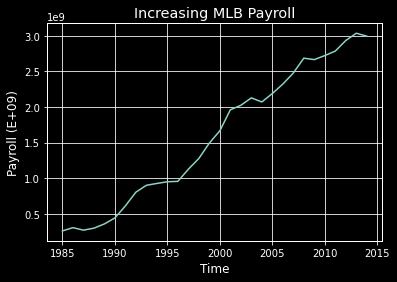

In [322]:
#Filtering data to prove that payrolls are increasing over time
x = team_df.pivot(index ='teamID', columns='yearID', values='total_payroll')
x = x.sum()
plt.plot(range(1985, 2015), x)
plt.title("Increasing MLB Payroll")
plt.xlabel("Time")
plt.ylabel("Payroll (E+09)")

## **Correlation Between Payroll and Winning Percentage**
### Problem 4
Write code to discretize year into five time periods (you can use pandas.cut to accomplish this) and then make a set of scatter plot showing mean winning percentage (y-axis) vs. mean payroll (x-axis) for each of the five time periods. Your time periods should be roughly 1990-1995, 1995-2000, 2000-2005, 2005-2010, 2010-2014.

Add a regression line (using, e.g., SciPy linregress) in each of the 5 scatter plot to ease interpretation.

Label each point with the team or franchise using something like this. You may need to read over the documentation for the annotate function.

Hint: To do this you may need to extract the axis object from the plotting call and add things to it as we did in Lab 5.

In [323]:
# Dividing years into five time periods
periods = [1990,1995,2000,2005,2010,2015]
group_names=['1990_1994','1995_1999','2000_2004','2005_2009','2010_2014']
team_df['period'] = pd.cut(team_df['yearID'],periods,right=False, labels=group_names)
team_df

,yearID,teamID,total_payroll,W,G,franchID,win_rate,period,average,standardDev,std_payroll,expected_win_pct,efficiency
0,1997,ANA,31135472.0,84,162,ANA,51.851852,1995_1999,3.933794e+07,1.351425e+07,-0.606949,48.482626,3.369225
1,1998,ANA,41281000.0,85,162,ANA,52.469136,1995_1999,4.173886e+07,1.562189e+07,-0.029309,49.926727,2.542409
2,1999,ANA,55388166.0,70,162,ANA,43.209877,1995_1999,4.886377e+07,2.054797e+07,0.317520,50.793801,-7.583925
3,2000,ANA,51464167.0,82,162,ANA,50.617284,2000_2004,5.444197e+07,2.156598e+07,-0.138079,49.654803,0.962481
4,2001,ANA,47535167.0,75,162,ANA,46.296296,2000_2004,6.405176e+07,2.494139e+07,-0.662216,48.344459,-2.048163
...,...,...,...,...,...,...,...,...,...,...,...,...,...
853,2010,WAS,61400000.0,69,162,WSN,42.592593,2010_2014,8.901233e+07,3.802230e+07,-0.726214,48.184465,-5.591872
854,2011,WAS,63856928.0,80,161,WSN,49.689441,2010_2014,9.113049e+07,4.053976e+07,-0.672761,48.318098,1.371343
855,2012,WAS,80855143.0,98,162,WSN,60.493827,2010_2014,9.580403e+07,3.718363e+07,-0.402029,48.994929,11.498899
856,2013,WAS,113703270.0,86,162,WSN,53.086420,2010_2014,9.944110e+07,4.814834e+07,0.296213,50.740533,2.345887


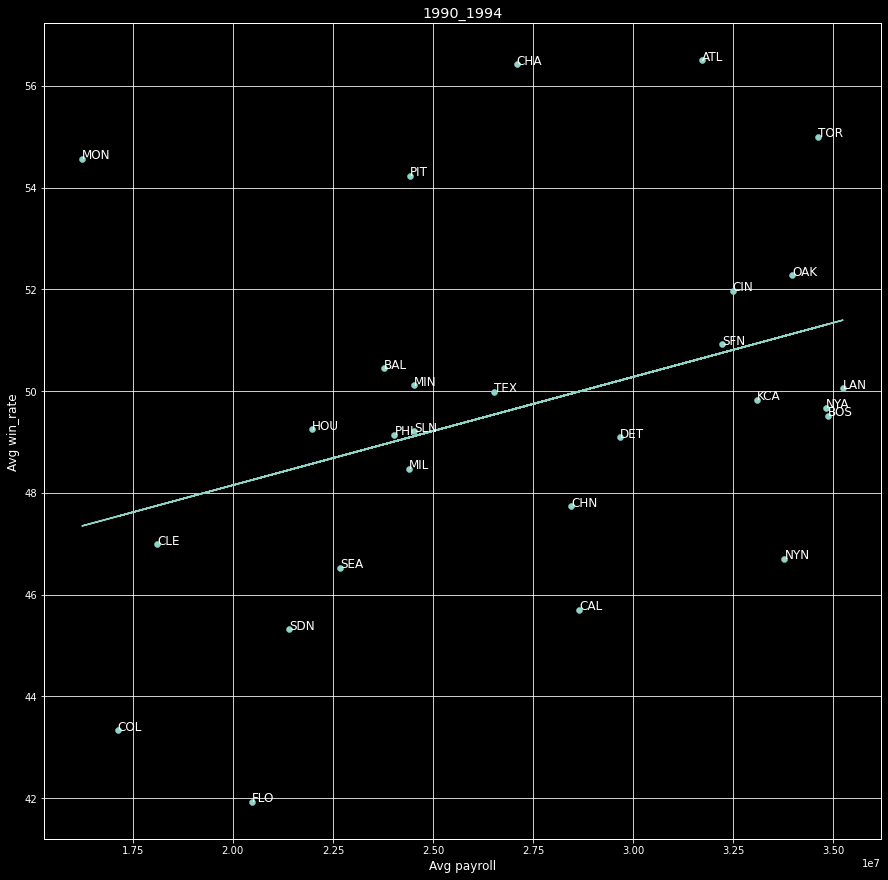

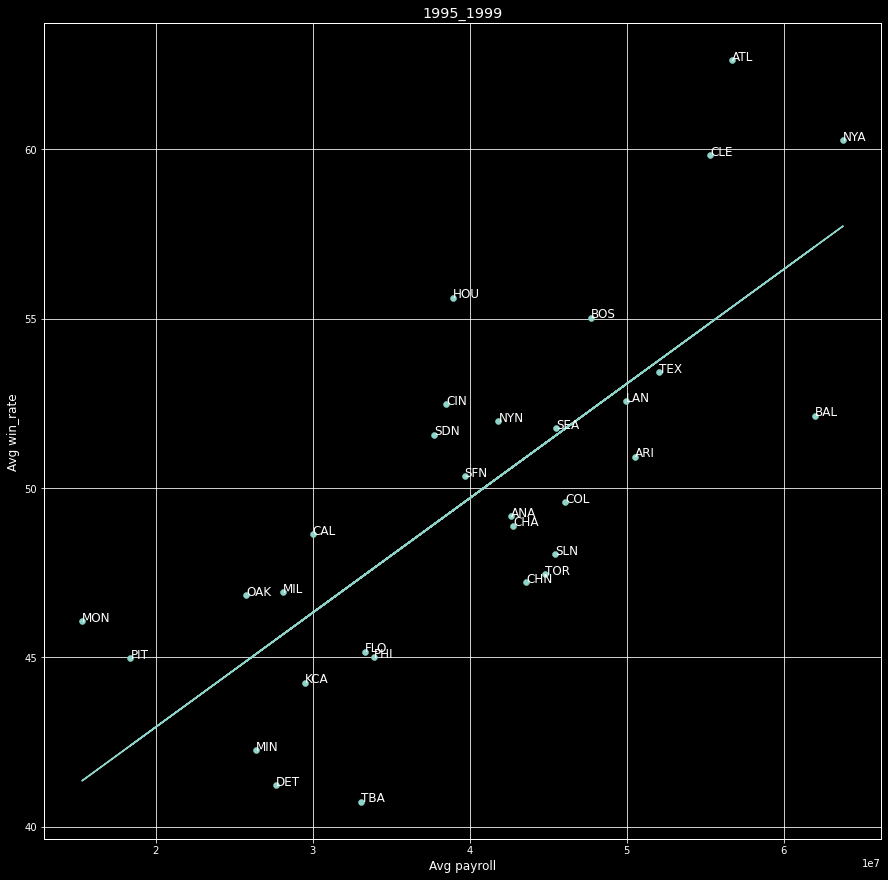

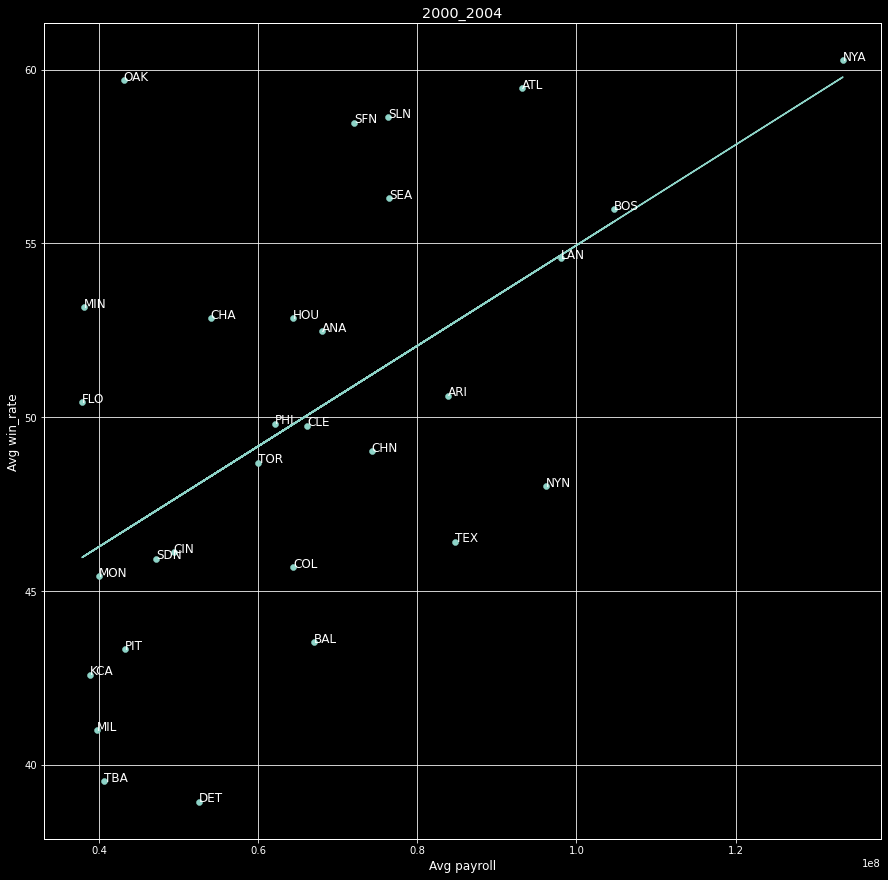

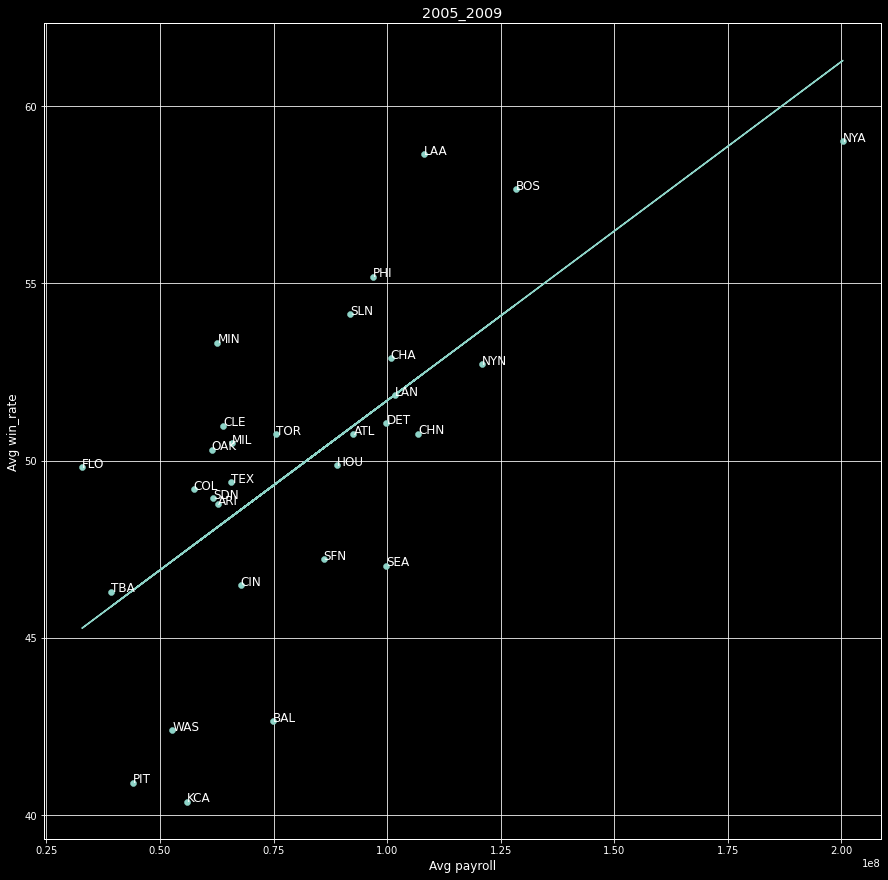

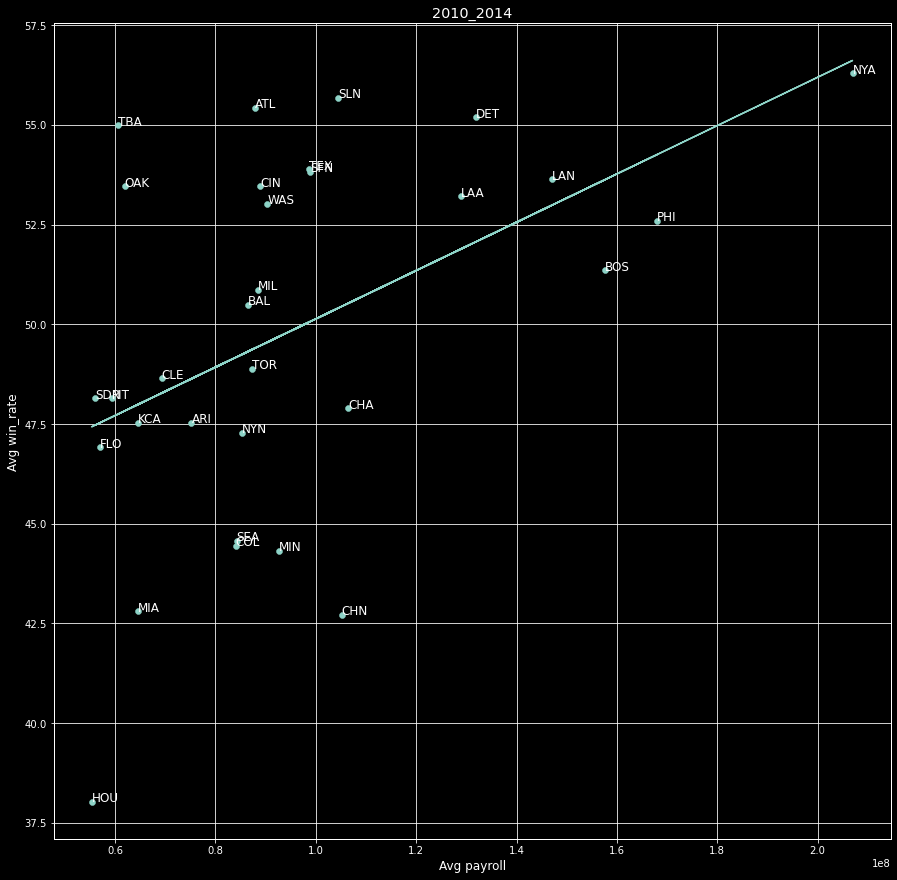

In [324]:
#Making one scatter plot for every period showing winning percentage vs mean payroll
for period in group_names:
    # Calculating avg total_payroll and win_rate for each team on each period
    s = team_df[team_df.period  == period]
    pr = s.pivot(index='yearID', columns='teamID', values='total_payroll')
    wr = s.pivot(index='yearID', columns='teamID', values='win_rate')
    x_data = pr.mean().values
    y_data = wr.mean().values
    # Drawing regression line using polyfit 
    fit = np.polyfit(x_data,y_data,deg = 1)
    plt.figure(figsize = (15,15))
    plt.plot(x_data, fit[0] * x_data + fit[1])
    #Plot
    plt.scatter(x_data, y_data)
    pr = pr.transpose()
    # Using Annotate to label each point in the scatterplot
    for i, name in enumerate(pr.index):
        plt.annotate(name, (x_data[i],y_data[i]),size=12)
    plt.xlabel("Avg payroll")
    plt.ylabel("Avg win_rate")
    plt.title(period)
    plt.show()

### **Question 2**

What can you say about team payrolls across these periods? Are there any teams that standout as being particularly good at paying for wins across these time periods? What can you say about the Oakland A’s spending efficiency across these time periods and specifically in the Moneyball period of 2000-2005.

There is a leftward shift in the Avg win rate vs Avg payroll figures after the 1995-1999 plot. This could be attributed to the events in Moneyball where teams realized that they were misvaluing their players. One particular team that stands out to me is the Atlanta Braves who are getting better average win rates with the payroll that they have. They have been fairly above the regression line in all the figures

The Oakland Athletics are doing INSANELY good during the 2000-2004 period. It is clear that they are getting excelent win rates and value for their budget compared to every other team in this time period

# Part 3: Data Transformations


## Standardizing Across Years
### **Problem 5**
Create a new variable in your dataset that standardizes payroll conditioned on year. For this we will compute the Z-score of the variables. So, this column for team i in year j should equal: $$ standardized\_payroll_{ij} = \frac{payroll_{ij} - avg\_payroll_{j}}{s_j}$$

In [325]:
l1 = []
l2 = []
for i, row in team_df.iterrows():
    a = 0
    for year in s_new:
        if (year == (row['yearID'])):
            l1.append(s_new[year].Average)
            l2.append(s_new[year].StandardDev)
            a = a + 1
    if (a == 0):
        l1.append(np.NaN)
        l2.append(np.NaN)
# Adding information to the table 
averages = pd.DataFrame(l1, columns = ['raw'])
team_df['average'] = averages           
stddevs = pd.DataFrame(l2, columns = ['raw'])
team_df['standardDev'] = stddevs
# Adding column calculating the standard payroll of each team to its corresponding year
team_df['std_payroll'] = (team_df['total_payroll']-team_df['average'])/ (team_df['standardDev'])
team_df

,yearID,teamID,total_payroll,W,G,franchID,win_rate,period,average,standardDev,std_payroll,expected_win_pct,efficiency
0,1997,ANA,31135472.0,84,162,ANA,51.851852,1995_1999,3.933794e+07,1.351425e+07,-0.606949,48.482626,3.369225
1,1998,ANA,41281000.0,85,162,ANA,52.469136,1995_1999,4.173886e+07,1.562189e+07,-0.029309,49.926727,2.542409
2,1999,ANA,55388166.0,70,162,ANA,43.209877,1995_1999,4.886377e+07,2.054797e+07,0.317520,50.793801,-7.583925
3,2000,ANA,51464167.0,82,162,ANA,50.617284,2000_2004,5.444197e+07,2.156598e+07,-0.138079,49.654803,0.962481
4,2001,ANA,47535167.0,75,162,ANA,46.296296,2000_2004,6.405176e+07,2.494139e+07,-0.662216,48.344459,-2.048163
...,...,...,...,...,...,...,...,...,...,...,...,...,...
853,2010,WAS,61400000.0,69,162,WSN,42.592593,2010_2014,8.901233e+07,3.802230e+07,-0.726214,48.184465,-5.591872
854,2011,WAS,63856928.0,80,161,WSN,49.689441,2010_2014,9.113049e+07,4.053976e+07,-0.672761,48.318098,1.371343
855,2012,WAS,80855143.0,98,162,WSN,60.493827,2010_2014,9.580403e+07,3.718363e+07,-0.402029,48.994929,11.498899
856,2013,WAS,113703270.0,86,162,WSN,53.086420,2010_2014,9.944110e+07,4.814834e+07,0.296213,50.740533,2.345887


### **Problem 6**
Repeat the same plots as Problem 4, but use this new standardized payroll variable. Remember that you should have one plot for each of the 5 time periods.

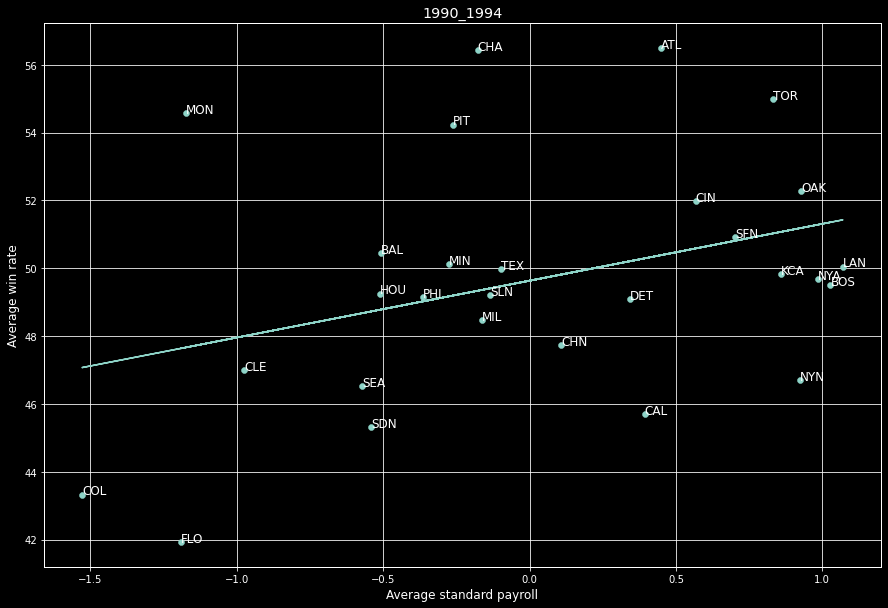

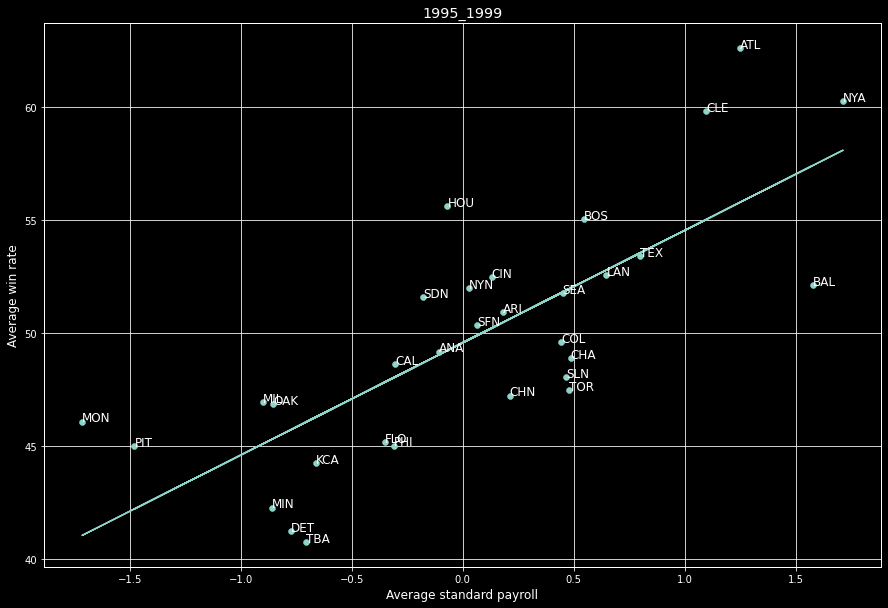

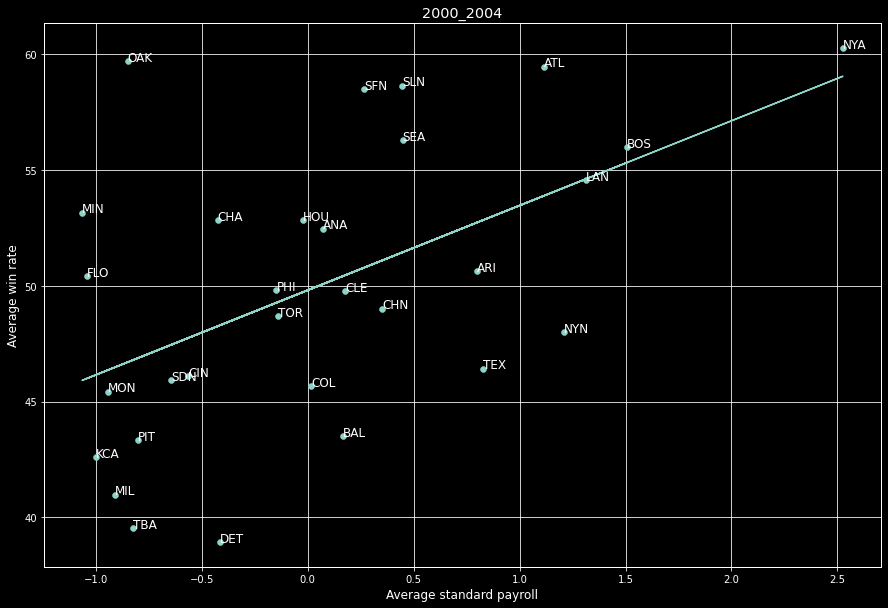

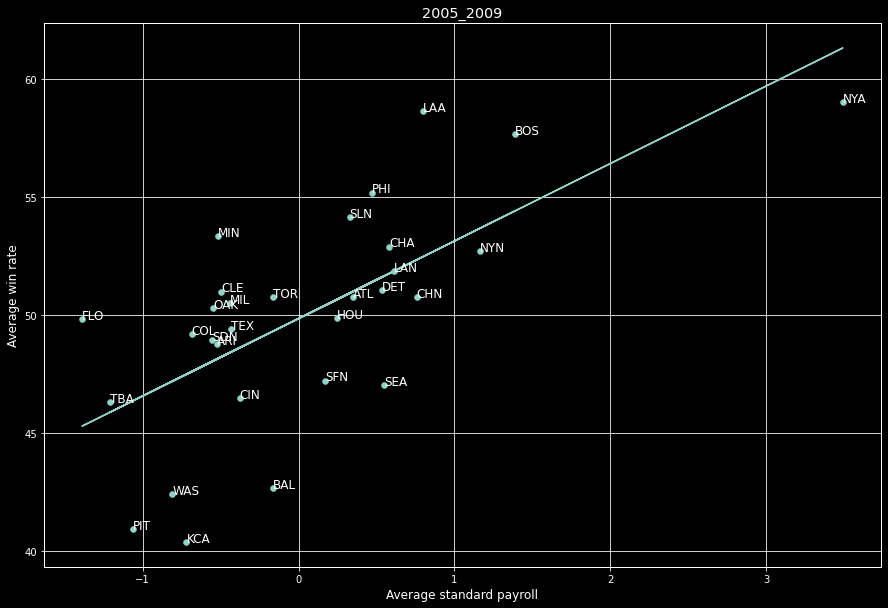

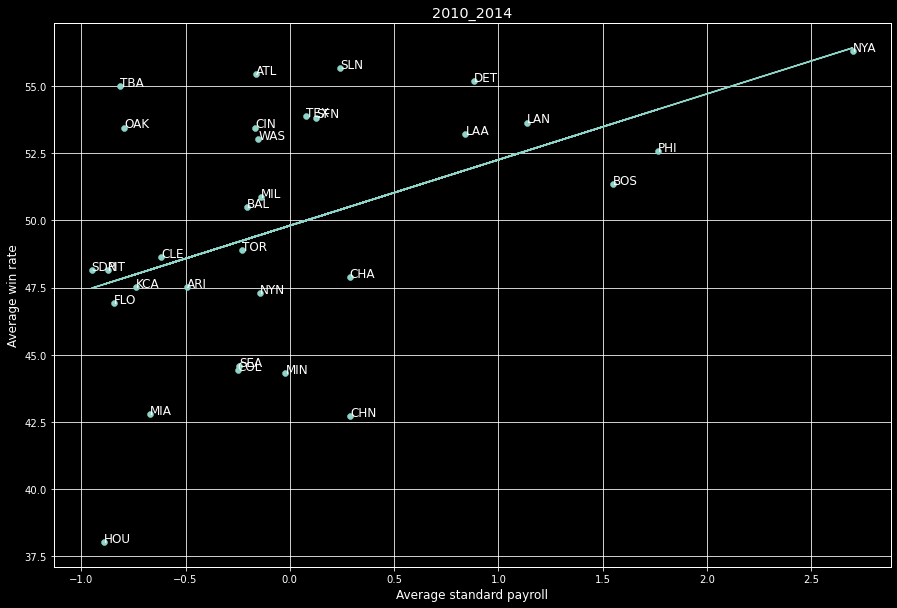

In [326]:

for period in group_names:
    # Calculating avg std payroll and win_rate for each team on each period
    s = team_df[team_df.period  == period]
    pr = s.pivot(index='yearID', columns='teamID', values='std_payroll')
    wr = s.pivot(index='yearID', columns='teamID', values='win_rate')
    x_data = pr.mean().values
    y_data = wr.mean().values
    
    # Drawing the regression line
    fit = np.polyfit(x = x_data,y = y_data,deg = 1)
    plt.figure(figsize = (15,10))
    
    #Making the scatter plot
    plt.plot(x_data, fit[0] * x_data + fit[1])
    plt.scatter(x_data, y_data)
    pr = pr.transpose()
    
    # Using Annotate to label each point in the scatterplot
    for i, name in enumerate(pr.index):
        plt.annotate(name, (x_data[i],y_data[i]),size=12)
    plt.xlabel("Average standard payroll")
    plt.ylabel("Average win rate")
    plt.title(period)
    plt.show()

### **Question 3**
Discuss how the plots from Problem 4 and Problem 6 reflect the transformation you did on the payroll variable. Specifically, what is easier to see, what is harder to see? Are any relationships more apparent?

Even with the X axis being reduced drastically in size we can still see arguably the same results and distances between points. It is easier to see how teams' spots in the graphs is much more consistent with each other.

## Expected Wins
It’s hard to see global trends across time periods using these multiple plots, but now that we have standardized payrolls across time, we can look at a single plot showing correlation between winning percentage and payroll across time.

### Problem 7
Make a **single scatter** plot of winning percentage (y-axis) vs. standardized payroll (x-axis). Add a regression line to highlight the relationship. You do not need to label the teams in this plot.

The regression line gives you expected winning percentage as a function of standardized payroll. Looking at the regression line, it looks like teams that spend roughly the average payroll in a given year will win 50% of their games (i.e. win_pct is 50 when standardized_payroll is 0), and teams increase 5% wins for every 2 standard units of payroll (i.e., win_pct is 55 when standardized_payroll is 2). We will see how this is done in general using linear regression later in the course.

From these observations we can calculate the expected win percentage for team i in year j as $$ expected\_win\_pct_{ij} = 50 + 2.5 \times standardized\_payroll_{ij}$$


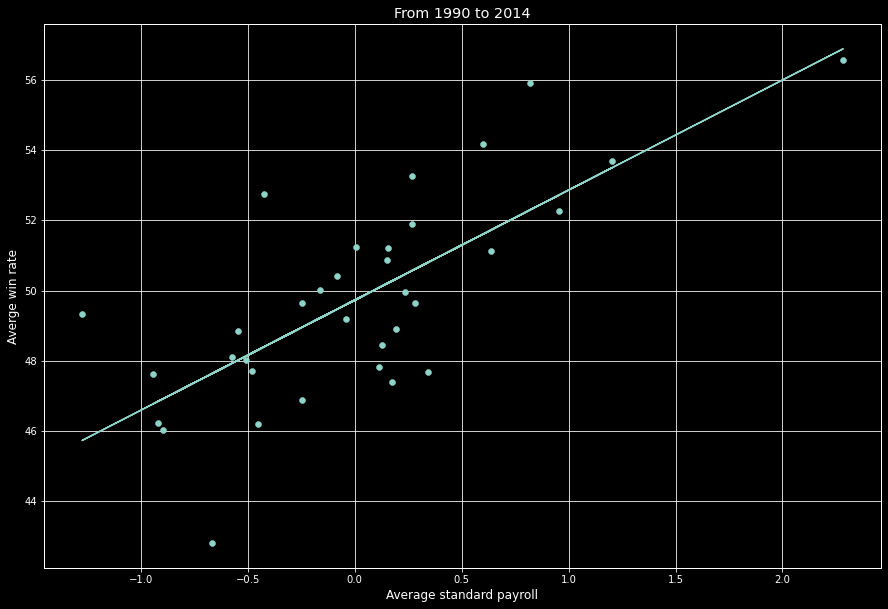

In [327]:
# Calculating avg total_payroll and win_rate for each team
pr = team_df.pivot(index='yearID', columns='teamID', values='std_payroll')
wr = team_df.pivot(index='yearID', columns='teamID', values='win_rate')
x_data = pr.mean().values
y_data = wr.mean().values

#Drawing regression line
fit = np.polyfit(x = x_data,y = y_data,deg = 1)
plt.figure(figsize = (15,10))

#Making plot
plt.plot(x_data, fit[0] * x_data + fit[1])
plt.scatter(x_data, y_data)
pr = pr.transpose()

plt.xlabel("Average standard payroll")
plt.ylabel("Averge win rate")
plt.title("From 1990 to 2014")
plt.show()

In [328]:
#Creating expected_win_pct using given formula
team_df['expected_win_pct'] = 50 + 2.5*team_df['std_payroll']
team_df

,yearID,teamID,total_payroll,W,G,franchID,win_rate,period,average,standardDev,std_payroll,expected_win_pct,efficiency
0,1997,ANA,31135472.0,84,162,ANA,51.851852,1995_1999,3.933794e+07,1.351425e+07,-0.606949,48.482626,3.369225
1,1998,ANA,41281000.0,85,162,ANA,52.469136,1995_1999,4.173886e+07,1.562189e+07,-0.029309,49.926727,2.542409
2,1999,ANA,55388166.0,70,162,ANA,43.209877,1995_1999,4.886377e+07,2.054797e+07,0.317520,50.793801,-7.583925
3,2000,ANA,51464167.0,82,162,ANA,50.617284,2000_2004,5.444197e+07,2.156598e+07,-0.138079,49.654803,0.962481
4,2001,ANA,47535167.0,75,162,ANA,46.296296,2000_2004,6.405176e+07,2.494139e+07,-0.662216,48.344459,-2.048163
...,...,...,...,...,...,...,...,...,...,...,...,...,...
853,2010,WAS,61400000.0,69,162,WSN,42.592593,2010_2014,8.901233e+07,3.802230e+07,-0.726214,48.184465,-5.591872
854,2011,WAS,63856928.0,80,161,WSN,49.689441,2010_2014,9.113049e+07,4.053976e+07,-0.672761,48.318098,1.371343
855,2012,WAS,80855143.0,98,162,WSN,60.493827,2010_2014,9.580403e+07,3.718363e+07,-0.402029,48.994929,11.498899
856,2013,WAS,113703270.0,86,162,WSN,53.086420,2010_2014,9.944110e+07,4.814834e+07,0.296213,50.740533,2.345887


## Spending Efficiency
Using this result, we can now create a single plot that makes it easier to compare teams efficiency. The idea is to create a new measurement unit for each team based on their winning percentage and their expected winning percentage that we can plot across time summarizing how efficient each team is in their spending.

### Problem 8
Create a new field to compute each team’s spending efficiency, given by:
$$efficiency_{ij} = win\_pct_{ij} - expected\_win\_pct_{ij}$$
for team i in year j, where expected_win_pct is given above.

Make a line plot with year on the x-axis and efficiency on the y-axis. A good set of teams to plot are Oakland, the New York Yankees, Boston, Atlanta and Tampa Bay (teamIDs OAK, BOS, NYA, ATL, TBA).

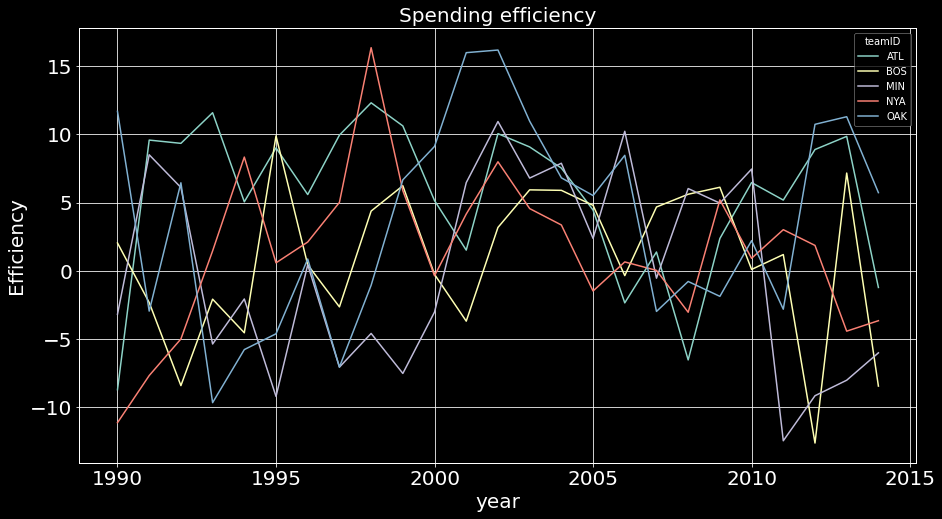

In [332]:
team_df['efficiency'] = team_df['win_rate'] - team_df['expected_win_pct']

# specifying year limits for efficiency
team_efficiency = team_df[team_df.yearID > 1989]
team_efficiency = team_efficiency[team_efficiency.yearID < 2015]

# Getting efficiency data for 5 teams
oak = team_efficiency[team_efficiency.teamID == 'OAK' ]
bos = team_efficiency[team_efficiency.teamID == 'BOS' ]
nya = team_efficiency[team_efficiency.teamID == 'NYA' ]
min = team_efficiency[team_efficiency.teamID == 'MIN' ]
atl = team_efficiency[team_efficiency.teamID == 'ATL' ]

# aggregating teams efficiency
teams = [oak, bos, nya, min, atl]
team_efficiency = pd.concat(teams)

# Plotting effciency and corresponding year for each team ( OAK, BOS, NYA, MIN, ATL).
team_efficiency = team_efficiency.pivot(index='yearID', columns='teamID', values='efficiency')
team_efficiency.plot(kind = 'line', figsize=(15, 8), legend=True, fontsize=20)
plt.title("Spending efficiency",fontsize=20)
plt.xlabel("year", fontsize=20)
plt.ylabel("Efficiency", fontsize=20)
plt.show()

### Question 4
What can you learn from this plot compared to the set of plots you looked at in Question 2 and 3? How good was Oakland’s efficiency during the Moneyball period?

The power of this plot is that you can view each team's spending efficiency in the same figure. This allows for more observations to be made regarding each team's ability to have a succesfull win rate. We can see how oakland peaked between 2001 and 2003 and how everyone's efficiency was lowered after teams realized how to "properly" evaluate players. Oakland reached the same level of efficiency than the Yankees around 1997 using only a fraction of the budget. If we take a look at the the charts above we see that they both had around a 60 percent win_rate. My observation is that win_rate is more correlated to spending efficiency than to budget.